In [1]:
from astropy.io import fits
import astropy.nddata
from astropy.io import ascii
from astropy.nddata import CCDData
import glob
import os
import astroalign as aa
import ccdproc
import numpy as np
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt

#### Alignment

In [2]:
#we select one image as reference, then we will align all the other images (on b and v band) respect to
#the first one.
reference_image = fits.open('/home/astro/Documenti/2023/2023-12-19/ngcbreduced/ngc654b.00000110.FIT')
source_image_b = '/home/astro/Documenti/2023/2023-12-19/ngcbreduced/'
aligned_b_dir =  '/home/astro/Documenti/2023/2023-12-19/ngcbaligned/'
for element in os.listdir(source_image_b):
    aligned_image, _ = aa.register(fits.open(source_image_b + element)[0], reference_image[0], min_area = 50) #pay attention to "alig
#ned_image, _" because the '_' allow us to ignore the boolean part inside the tuple that astroalign returns after this piece of code!!
#so then the image is not a cubic image which is interpreted as an image with 2 photograms by SAOImage DS9 (or another visualizator).
    array_image = np.array(aligned_image)
    fits.writeto(aligned_b_dir + element, array_image, overwrite = True)# DELETE IMAGE NUMBER 111   !!!!!!!!!!!!!!!!!!!!!!!!!
aligned_image

array([[83.        , 83.        , 83.        , ..., 63.6584864 ,
        86.53867324, 82.50435392],
       [83.        , 83.        , 83.        , ..., 95.80501912,
        97.57677689, 77.67155845],
       [83.        , 83.        , 83.        , ..., 85.09190213,
        95.51627083, 61.23800612],
       ...,
       [83.        , 83.        , 83.        , ..., 83.        ,
        83.        , 83.        ],
       [83.        , 83.        , 83.        , ..., 83.        ,
        83.        , 83.        ],
       [83.        , 83.        , 83.        , ..., 83.        ,
        83.        , 83.        ]])

In [3]:
print(aligned_image.shape)

(2712, 3388)


In [4]:
reference_image = fits.open('/home/astro/Documenti/2023/2023-12-19/ngcbreduced/ngc654b.00000110.FIT')#es la misma que antes
source_image_v = '/home/astro/Documenti/2023/2023-12-19/ngcvreduced/'
aligned_v_dir =  '/home/astro/Documenti/2023/2023-12-19/ngcvaligned/'
for element in os.listdir(source_image_v):
    aligned_image, _ = aa.register(fits.open(source_image_v + element)[0], reference_image[0], min_area = 50)
    array_image = np.array(aligned_image)
    fits.writeto(aligned_v_dir + element, array_image, overwrite = True)

#### Combination

In [5]:
b_director = '/home/astro/Documenti/2023/2023-12-19/ngcbaligned/*.FIT'
b_directory = glob.glob(b_director)
b_directory.sort()
b_images = [CCDData.read(element,unit='adu') for element in b_directory]
b_combined = ccdproc.Combiner(b_images)
b_average = b_combined.average_combine()
b_average = np.array(b_average)
fits.writeto('/home/astro/Documenti/2023/2023-12-19/ngcbaligned/'+'b_combined.FIT',b_average, overwrite = True)

In [6]:
v_director = '/home/astro/Documenti/2023/2023-12-19/ngcvaligned/*.FIT'
v_directory = glob.glob(v_director)
v_directory.sort()
v_images = [CCDData.read(element,unit='adu') for element in v_directory]
v_combined = ccdproc.Combiner(v_images)
v_average = v_combined.average_combine()
v_average = np.array(v_average)
fits.writeto('/home/astro/Documenti/2023/2023-12-19/ngcvaligned/'+'v_combined.FIT',v_average, overwrite = True)

#### Tables creation with sextractor

In [7]:
os.chdir('/home/astro/Documenti/2023/2023-12-19/ngcbaligned/')
sp.run(['sex {} -c myconf.txt'.format(b_combined)], shell=True, stderr = sp.DEVNULL)

CompletedProcess(args=['sex <ccdproc.combiner.Combiner object at 0x71dd7660f310> -c myconf.txt'], returncode=2)

In [8]:
os.chdir('/home/astro/Documenti/2023/2023-12-19/ngcbaligned')
sp.run(['sex b_combined.FIT -c myconf.txt'], shell=True, stderr = sp.DEVNULL)
bdata = ascii.read("output.src")
bdf = bdata.to_pandas()
os.chdir('/home/astro/Documenti/2023/2023-12-19/ngcvaligned')
sp.run(['sex v_combined.FIT -c myconf.txt'], shell=True, stderr = sp.DEVNULL)
vdata = ascii.read("output.src")
vdf = vdata.to_pandas()
#hacer coincidir las estrellas de cada tabla v y b y comparar magnitudes
#colocar los valores color y magnitud a una nueva lista

In [9]:
bdf

,MAG_APER,MAGERR_APER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,FLAGS,FWHM_IMAGE
0,7.1337,0.0058,8.9215,41.1148,0.000070,0.000049,18,0.00
1,6.2163,0.0036,8.9103,62.1345,0.000015,0.000215,18,4.57
2,5.5851,0.0027,8.9041,98.5460,0.000015,0.000342,26,4.01
3,7.5367,0.0075,281.1864,181.4814,0.001816,0.001505,0,14.04
4,5.3358,0.0024,15.2380,125.1660,0.000076,0.000111,18,1.58
...,...,...,...,...,...,...,...,...
231,10.3631,0.0557,277.8562,1984.9034,0.017860,0.012870,0,15.98
232,6.3293,0.0039,991.4265,2055.2488,0.000496,0.000397,0,12.04
233,10.1029,0.0449,3170.4658,2338.0803,0.020158,0.012538,0,20.05
234,7.6196,0.0078,2435.3752,2366.5085,0.001797,0.001370,0,13.27


In [10]:
bdf1 = bdf[(bdf['FLAGS'] == 0) & (bdf['X_IMAGE'] > 115)]
bdf1

,MAG_APER,MAGERR_APER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,FLAGS,FWHM_IMAGE
3,7.5367,0.0075,281.1864,181.4814,0.001816,0.001505,0,14.04
5,9.4700,0.0272,2091.5876,157.9906,0.007878,0.007712,0,15.15
9,10.2917,0.0524,1480.4355,292.4062,0.016102,0.014714,0,16.80
14,9.5978,0.0300,160.8237,394.9692,0.009239,0.006533,0,14.53
16,8.7349,0.0159,793.8815,428.7977,0.004574,0.003787,0,14.00
...,...,...,...,...,...,...,...,...
231,10.3631,0.0557,277.8562,1984.9034,0.017860,0.012870,0,15.98
232,6.3293,0.0039,991.4265,2055.2488,0.000496,0.000397,0,12.04
233,10.1029,0.0449,3170.4658,2338.0803,0.020158,0.012538,0,20.05
234,7.6196,0.0078,2435.3752,2366.5085,0.001797,0.001370,0,13.27


In [11]:
vdf1 = vdf[(vdf['FLAGS'] == 0) & (vdf['X_IMAGE'] > 115)]
vdf1

,MAG_APER,MAGERR_APER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,FLAGS,FWHM_IMAGE
3,6.4890,0.0043,281.3178,181.6697,0.000854,0.000560,0,15.46
4,8.4353,0.0140,2091.4653,157.9842,0.005241,0.003558,0,16.58
11,9.1818,0.0243,1480.2961,292.9681,0.009026,0.005667,0,16.91
13,9.0681,0.0223,2720.9299,319.7833,0.012309,0.011313,0,26.77
18,8.1546,0.0116,160.8767,395.2487,0.003789,0.002370,0,15.45
...,...,...,...,...,...,...,...,...
237,9.5582,0.0327,2623.0005,1997.3839,0.013754,0.007217,0,19.40
238,9.7532,0.0383,2982.6194,2138.9846,0.016576,0.011273,0,21.11
242,8.1891,0.0119,3190.8503,2047.1755,0.004257,0.002744,0,16.62
243,9.4515,0.0300,1446.4192,1948.4326,0.012269,0.010974,0,22.57


In [12]:
mag_b = []
mag_v = []
for _, row_b in bdf1.iterrows():  # Itera sobre cada fila del primer DataFrame
    for _, row_v in vdf1.iterrows():  # Itera sobre cada fila del segundo DataFrame
        if abs(row_b['X_IMAGE'] - row_v['X_IMAGE']) <= 2 and abs(row_b['Y_IMAGE'] - row_v['Y_IMAGE']) <= 2:
            # Comparación de las coordenadas X e Y para determinar si están dentro del rango
            mag_b.append(row_b['MAG_APER'])
            mag_v.append(row_v['MAG_APER'])
data = {'MAG_B': mag_b, 'MAG_V': mag_v}
df_match = pd.DataFrame(data)
df_match['B-V'] = df_match['MAG_B'] - df_match['MAG_V']
df_match

,MAG_B,MAG_V,B-V
0,7.5367,6.4890,1.0477
1,9.4700,8.4353,1.0347
2,10.2917,9.1818,1.1099
3,9.5978,8.1546,1.4432
4,8.7349,7.9094,0.8255
...,...,...,...
89,7.2907,6.5986,0.6921
90,9.6560,8.7839,0.8721
91,6.3293,5.6619,0.6674
92,7.6196,6.1750,1.4446


#### GRAPHICS

In [13]:
###########CALIBRATION WITH STAR (((BD+61 315)))
referencia_b1 = bdf[(bdf['FLAGS'] == 0) & (bdf['X_IMAGE'] > 2184) & (bdf['X_IMAGE'] < 2200) & (bdf['Y_IMAGE'] > 2055) & (bdf['Y_IMAGE'] < 2068)]
referencia_b1
referencia_v1 = vdf[(vdf['FLAGS'] == 0) & (vdf['X_IMAGE'] > 2184) & (vdf['X_IMAGE'] < 2200) & (vdf['Y_IMAGE'] > 2055) & (vdf['Y_IMAGE'] < 2068)]
referencia_v1
mins_b = referencia_b1['MAG_APER']
mins_b = mins_b.iloc[0]
mins_v = referencia_v1['MAG_APER']
mins_v = mins_v.iloc[0]
m_ap_b = 10.320 #From aladin
m_ap_v = 9.540 #From aladin
#mag = log(flux) + constant
coef_b = m_ap_b-mins_b
coef_v = m_ap_v-mins_v

In [14]:
coef_v
#5.549399999999999

5.549399999999999

In [15]:
coef_b
#5.3764

5.3764

In [16]:
df_match['MAG_V'] = df_match['MAG_V'] + coef_v
df_match['MAG_B'] = df_match['MAG_B'] + coef_b

Text(0.5, 0, 'Color')

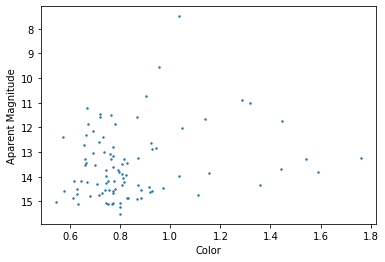

In [17]:
df_match.plot('B-V','MAG_V', kind = 'scatter', s=2)
plt.gca().invert_yaxis()
plt.ylabel('Aparent Magnitude')
plt.xlabel('Color')

In [18]:
v_abs = np.array([])
mag_v = np.array(mag_v)
v_abs = mag_v - 5*np.log10(240)
df_match['V_ABS'] = v_abs

Text(0.5, 0, 'Color')

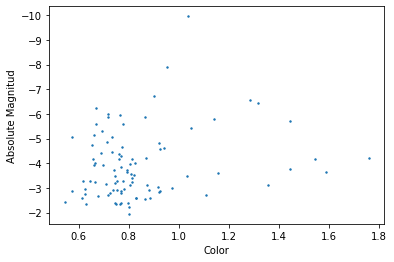

In [19]:
df_match.plot('B-V','V_ABS', kind = 'scatter', s=2)
plt.gca().invert_yaxis()
plt.ylabel('Absolute Magnitud')
plt.xlabel('Color')